# Image Postprocessing of Cavitation Images

This program loads images from Photron BC2HD and performs a basic background correction

    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 D.Duke
    @license GPL-3.0+
    @version 0.0.1
    @date 09/10/2025
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [1]:
# core functions for image handling and plotting
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os, copy
import matplotlib.pyplot as plt
%matplotlib widget

In [3]:
# image processing tools
import scipy.ndimage
#from skimage import feature

In [4]:
# Define where images come from.
source_images = "/Volumes/SabrentRAID/HPR Pintle/3_1_1_1_88bar.mraw"
source_bkgnd = "/Volumes/SabrentRAID/HPR Pintle/background.mraw"

In [17]:
# Read in some background images.
B=ImageSequence(source_bkgnd, monochrome=False, width=1024, height=640, rawtype='photron_mraw_color_12bit',\
               frames=(0,100))

Reading /Volumes/SabrentRAID/HPR Pintle/background.mraw
PFV 12-bit MRAW
File contains 444 frames (1024 x 640)
Reading frames 0 to 100
Read 281.0 MiB in 2.3 sec
	Data in memory:	 (100, 3, 640, 1024)
	Intensity range:	 0 to 1922 	 uint16
	Array size:	375.0 MB


In [18]:
# Read in some spray images. 
I=ImageSequence(source_images, monochrome=False, width=1024, height=640, rawtype='photron_mraw_color_12bit',\
               frames=(600,800))

Reading /Volumes/SabrentRAID/HPR Pintle/3_1_1_1_88bar.mraw
PFV 12-bit MRAW
File contains 3624 frames (1024 x 640)
Reading frames 600 to 800
Read 562.0 MiB in 4.7 sec
	Data in memory:	 (200, 3, 640, 1024)
	Intensity range:	 0 to 3660 	 uint16
	Array size:	750.0 MB


In [19]:
# Make a function to convert array to a colour RGB format that imshow likes.
# i.e. rearrange the axes from (frames, rgb, y, x) to (frames, y, x, rgb).
def mplColor(I):
    return np.roll(np.rollaxis(I,0,3),2,0)/np.nanmax(I)

## Background Corrections

In [20]:
# Time-average background
Bavg = np.mean(B.arr,axis=0)

# Background color removal (sum of R+G+B signals)
Bavg_mono = Bavg[0,...]+Bavg[1,...]+Bavg[2,...]

# Boost the minimum level to avoid division by zero later.
# The number chosen for the mask here is arbitrary.
# I let it be 1% of the max intensity.
threshold=0.01*np.nanmax(Bavg_mono)
print("The raw counts for the threshold is: %i" % threshold)
Bavg_monoAdj = Bavg_mono[...]
Bavg_monoAdj[Bavg_monoAdj<threshold]=threshold
print("Background time-average min=%i, max=%i counts" % (Bavg_monoAdj.min(),Bavg_monoAdj.max()))

The raw counts for the threshold is: 35
Background time-average min=35, max=3592 counts


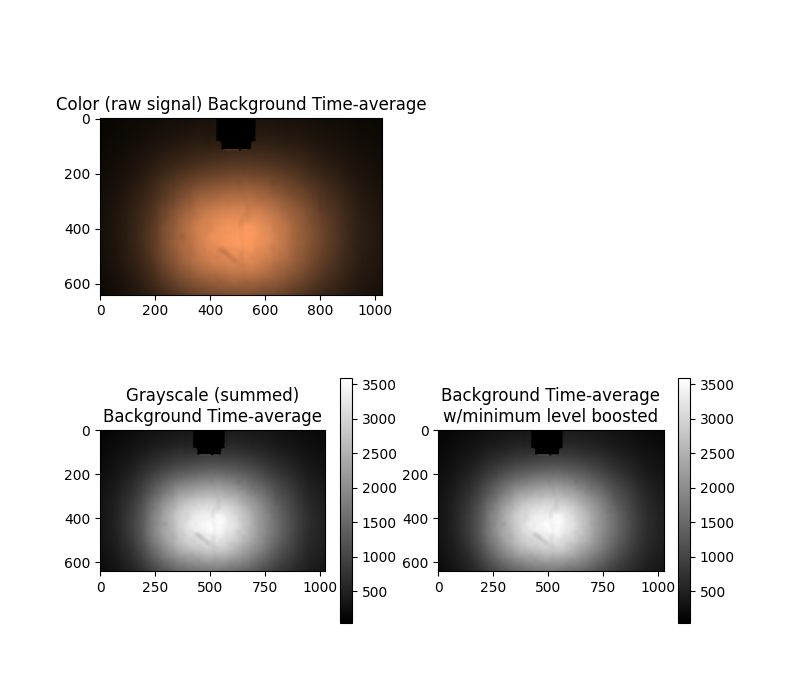

In [21]:
# Plot our progress.
fig=plt.figure(figsize=(8,7))
ax=fig.add_subplot(221)
ax.set_title("Color (raw signal) Background Time-average")
ax.imshow(mplColor(Bavg))
ax=fig.add_subplot(223)
ax.set_title("Grayscale (summed)\nBackground Time-average")
p=ax.imshow(Bavg_mono,cmap='grey')
plt.colorbar(p)
ax=fig.add_subplot(224)
ax.set_title("Background Time-average\nw/minimum level boosted")
p=ax.imshow(Bavg_monoAdj,cmap='grey')
plt.colorbar(p);

In [10]:
# Clear background raw images to save RAM.
del(B)
del(Bavg)

# Background Removal

In [22]:
# First get the RGB sum of foreground images. Weighting can be adjusted if req'd.
Imono = I.arr[:,0,...]+I.arr[:,1,...]+I.arr[:,2,...]

# Now remove the average background by division, and convert to extinction (dimensionless).
Iproc = 1.0 - (Imono / Bavg_monoAdj)

In [23]:
# Mask the parts of the image blocked by the nozzle, where the background is below the threshold.
nozzle_mask = (Bavg_mono <= threshold) 
nozzle_mask = scipy.ndimage.binary_dilation(nozzle_mask,iterations=15) # grow the mask a few px

# apply the mask to every frame.
for i in range(Iproc.shape[0]):
    Iproc[i,...] = Iproc[i,...]*(1-nozzle_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.0].


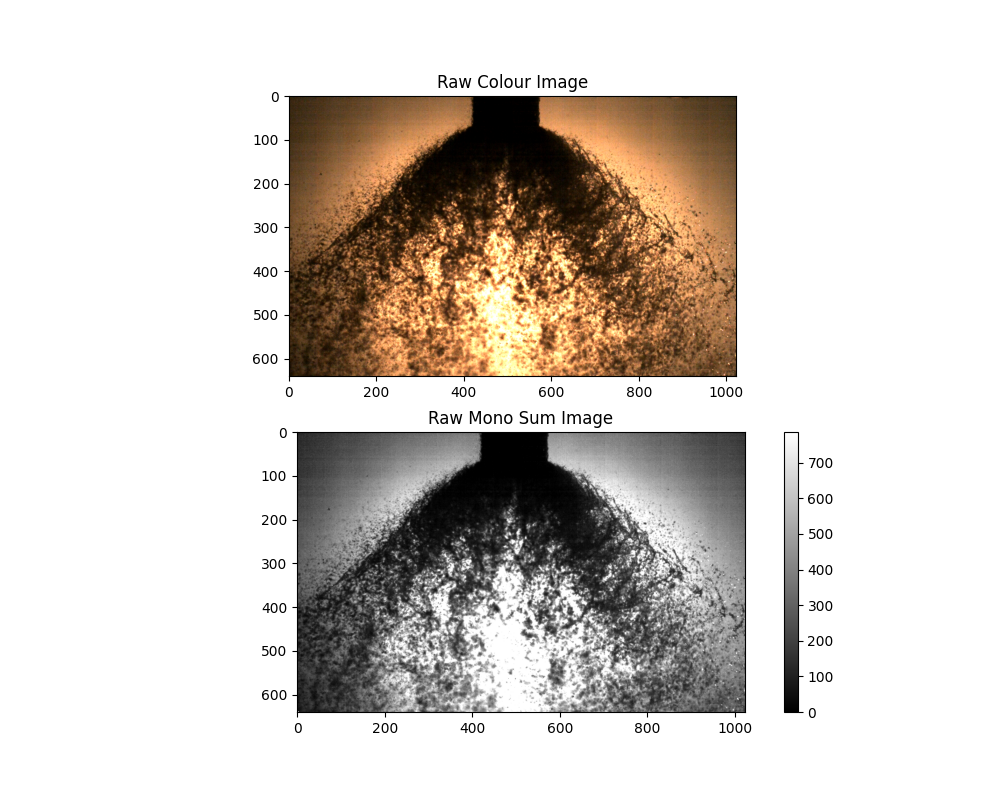

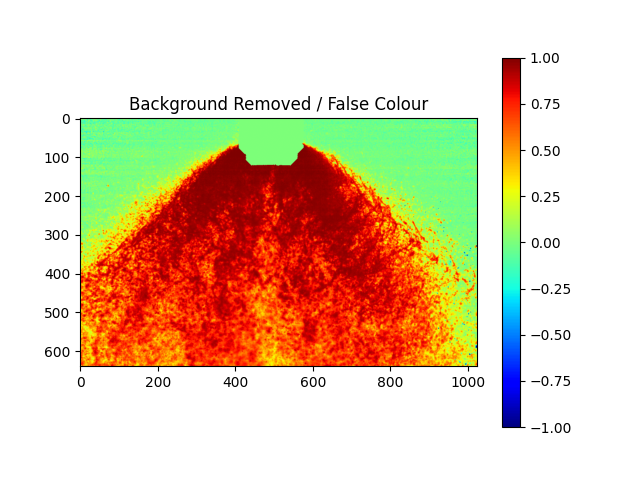

In [24]:
# Plot our progress
n=-1 # pick a frame to show, -1 is the last one.

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(211)
ax.set_title("Raw Colour Image")
Isample = I.arr[n,...]
ax.imshow(mplColor(I.arr[n,...])*4.0) # x4 is like 2 bit shift for viewing only
ax=fig.add_subplot(212)
ax.set_title("Raw Mono Sum Image")
p=ax.imshow(Imono[n,...],cmap='grey',vmin=0,vmax=Imono[n,...].max()/4.0) # clip maximum to 25%
plt.colorbar(p);

fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_title("Background Removed / False Colour")
p=ax.imshow(Iproc[n,...],cmap='jet',vmin=-1,vmax=1) # False colour lets us see the hidden detail in bright/dark area
plt.colorbar(p);
plt.subplots_adjust(hspace=0.25);

In [25]:
# Remove raw images to save RAM if we are satisfied with background removal.
del(I)

## Check some statistics of the time series

In [26]:
time_average = np.nanmean(Iproc,axis=0)
temporal_std = np.nanstd(Iproc,axis=0)

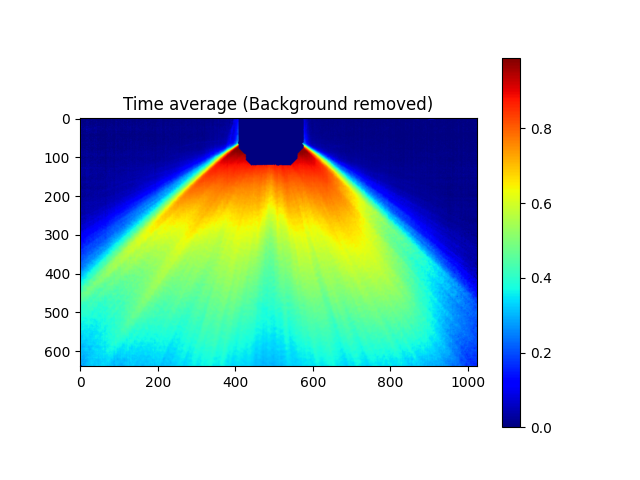

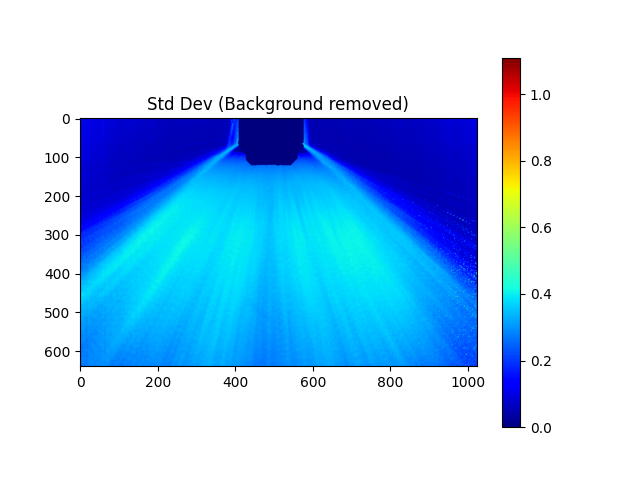

In [27]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_title("Time average (Background removed)")
p=ax.imshow(time_average,cmap='jet',vmin=0)
plt.colorbar(p);

fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_title("Std Dev (Background removed)")
p=ax.imshow(temporal_std,cmap='jet',vmin=0)
plt.colorbar(p);

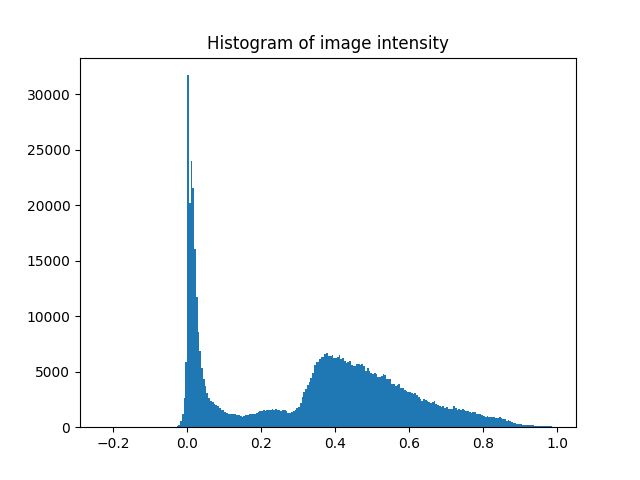

In [28]:
# Plot the histogram
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_title("Histogram of image intensity")
ax.hist(np.ravel(time_average),bins=256);

In the histogram, the left peak is the background and the right peak is the spray.

## Detect spray edge

In [216]:
# apply edge detection to find the spray edges.
# https://en.wikipedia.org/wiki/Sobel_operator
# This is not the best edge detection algorithm (it doesn't handle noise well) but it's good enough for this.

Iedge_x = scipy.ndimage.sobel(Iproc,axis=2)
Iedge_y = scipy.ndimage.sobel(Iproc,axis=1)
Iedge = np.sqrt(Iedge_x**2 + Iedge_y**2)

In [225]:
# The little droplets and background noise will return weak edges so we will hide those by masking out small edge values.
Iedge[Iedge<2.0]=0.0 # value is arbitrarily and manually set

# The nozzle lip will return quite a strong edge, so we will also remove that.
Iedge[Iedge>10.0]=10.0 # value is arbitrarily and manually set

In [257]:
# Binarise the strong and valid edges, and erode-dilate them so little droplets disappear.
Iedge_grow = Iedge>3.0 # this value is arbitrarily set a bit higher than the minimum value in prev step.
for n in range(Iedge.shape[0]):
  for m in range(2):
     Iedge_grow[n,...] = scipy.ndimage.binary_erosion(Iedge_grow[n,...],iterations=1) 
     Iedge_grow[n,...] = scipy.ndimage.binary_dilation(Iedge_grow[n,...],iterations=2) 

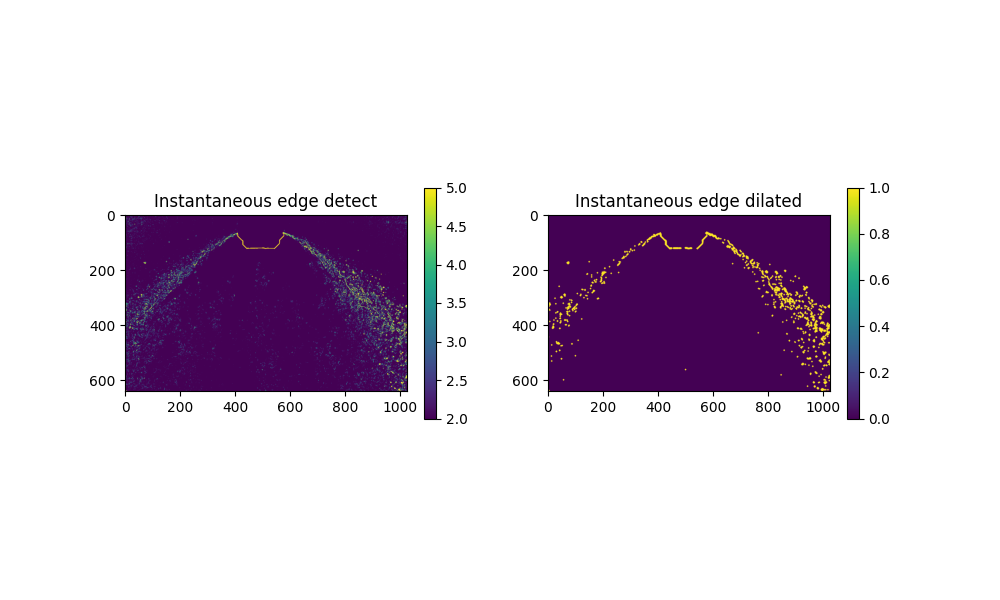

In [258]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(121)
ax.set_title("Instantaneous edge detect")
p=ax.imshow(Iedge[n,...],vmin=2,vmax=5)
plt.colorbar(p,shrink=.5);

ax=fig.add_subplot(122)
ax.set_title("Instantaneous edge dilated")
p=ax.imshow(Iedge_grow[n,...])
plt.colorbar(p,shrink=.5);

## Fit a centroid to the detected edge to estimate angle.

The centroid of the detected edge points (which can be messy) gives an estimate of where the edge of the spray is in any image.
We will simply plot versus the x axis and figure out the angle later assuming the spray is perfectly vertical (in y).

In [261]:
# Make matrix of coordinates
xvals = np.arange(Iedge_grow.shape[2])
yvals = np.arange(Iedge_grow.shape[1])
xgrid, ygrid = np.meshgrid(xvals,yvals)

# Mask for valid regions of the image (ignore near injector)
mask = (ygrid>50) * ((xgrid<420) | (xgrid>550))

# For each frame, calculate centroids in the y axis.
centroids = np.zeros((Iedge_grow.shape[0],Iedge_grow.shape[2]))
for n in range(Iedge_grow.shape[0]):
    centroids[n,:] = np.sum( ygrid * Iedge_grow[n,...] * mask, axis=0 ) / (np.sum( Iedge_grow[n,...] * mask, axis=0 ) + 1e-6)

# Hide bad points
centroids[centroids<=0] = np.nan

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_15884/3049335898.py:3: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(centroids,axis=0), lw=3, c='k');


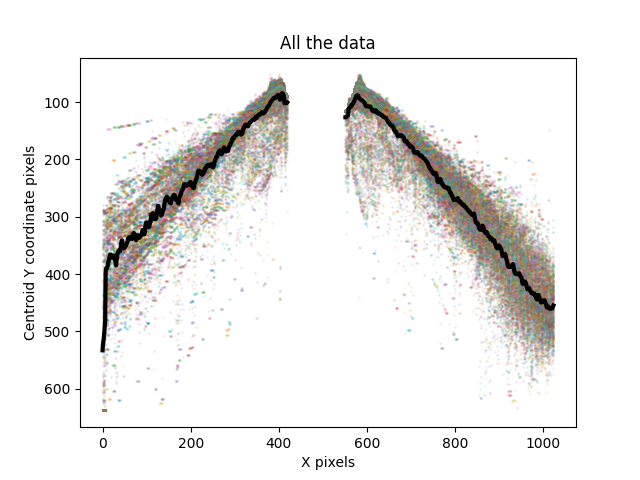

In [264]:
fig=plt.figure()
plt.plot(np.transpose(centroids), lw=1, ls='None', marker='.', markersize=2, alpha=.1)
plt.plot(np.nanmean(centroids,axis=0), lw=3, c='k');
plt.gca().invert_yaxis();
plt.xlabel('X pixels'); plt.ylabel('Centroid Y coordinate pixels');
plt.title("All the data");

From the above data, we could average every couple of frames and fit a curve to the two lines and get the angle as the gradient of a linear fit for example. This would give us a time-resolved angle , from which a mean & sd could be determined.

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_15884/4223763102.py:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(centroids[n:n+time_window,:],axis=0),lw=1, label='t=%i frames' % (n+time_window/2));


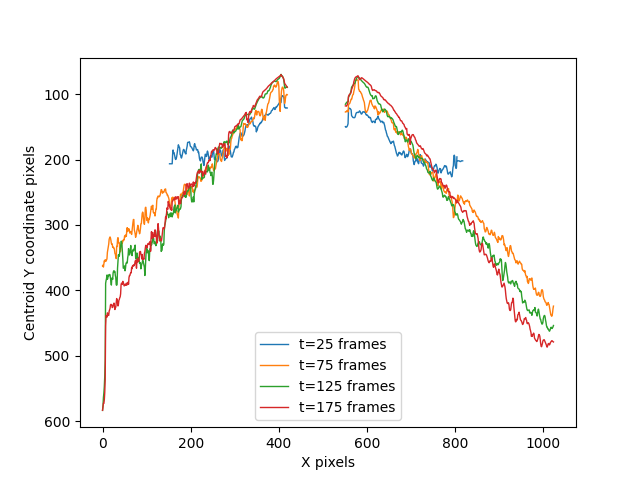

In [277]:
time_window = 50 # frames

fig=plt.figure()

for n in np.arange(0, centroids.shape[0], time_window):
    plt.plot(np.nanmean(centroids[n:n+time_window,:],axis=0),lw=1, label='t=%i frames' % (n+time_window/2));

plt.gca().invert_yaxis();
plt.xlabel('X pixels'); plt.ylabel('Centroid Y coordinate pixels');
plt.legend();